# WZE-UAV Image Classification using Deep Learning

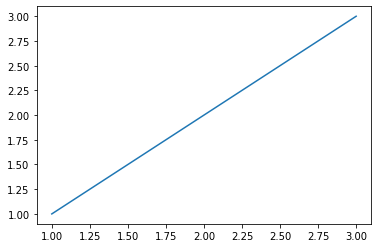

In [1]:
import os
import glob
import matplotlib.pyplot as plt
import rasterio
import numpy as np
import mlxtend
from pathlib import Path
from tqdm.auto import tqdm
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, classification_report


x = (1,3)
y = (1,3)
plt.plot(x,y)

In [2]:
import torch
import torchvision.transforms as T
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from torchmetrics import *
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, ReduceLROnPlateau
from mlxtend.plotting import plot_confusion_matrix
import h5py

In [3]:
import wze_uav.data_loader as data_loader
import wze_uav.visualization as visualization
import wze_uav.models as models
from wze_uav.engine import *
from wze_uav.utils2 import *
from wze_uav.log_writer import create_writer

#### Get PyTorch version

In [4]:
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchvision version: 0.14.1+cu116


#### Preparing device agnostic code 

In [5]:
# ensure device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

# get index of currently selected device
print(f"Index of current divice: {torch.cuda.current_device()}")
# get number of GPUs available
print(f"Number of GPUs available: {torch.cuda.device_count()}")
# get the name of the device
print(f"GPU Model: {torch.cuda.get_device_name(0)}")

cuda
Index of current divice: 0
Number of GPUs available: 1
GPU Model: Quadro RTX 8000


#### Ensure reproducibility 

In [6]:
# for more information, see also: https://pytorch.org/docs/stable/notes/randomness.html

# Set seeds
def set_seeds(seed: int=0):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 0.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# seed for numpy
np.random.seed(0)
# avoiding non-deterministic algorithms
#torch.use_deterministic_algorithms(True)
# Set to true -> might speed up the process but should be set to False if reproducible results are desired
torch.backends.cudnn.benchmark = True


#### Define file directories

In [7]:
set_seeds() # ensure reproducibility

# Data 2020
train_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\train"
val_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\val"
test_data_path = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2020\ROI\rgb\test"

# Data 2021
train_data_path_2021 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2021\ROI\rgb\train"
val_data_path_2021 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2021\ROI\rgb\val"
test_data_path_2021 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2021\ROI\rgb\test"

# Data 2022
train_data_path_2022 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2022\ROI\rgb\train"
val_data_path_2022 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2022\ROI\rgb\val"
test_data_path_2022 = r"D:\Drohnendaten\10_WZE-UAV\Auswertung_findatree\2022\ROI\rgb\test"



#### Load images and features (labels and tree species) from hdf5 files

In [8]:
# load all image and feature arrays from hdf5
# loops through all hdf5 files! 

# Data 2020
train_image_set_2020, train_label_set_2020, train_species_set_2020, train_kkl_set_2020, train_bk_set_2020 = data_loader.hdf5_to_img_label(train_data_path, load_sets = ["images_masked"])
val_image_set_2020, val_label_set_2020, val_species_set_2020, val_kkl_set_2020, val_bk_set_2020 = data_loader.hdf5_to_img_label(val_data_path, load_sets = ["images_masked"])
test_image_set_2020, test_label_set_2020, test_species_set_2020, test_kkl_set_2020, test_bk_set_2020 = data_loader.hdf5_to_img_label(test_data_path, load_sets = ["images_masked"])

# Data 2021
train_image_set_2021, train_label_set_2021, train_species_set_2021, train_kkl_set_2021, train_bk_set_2021 = data_loader.hdf5_to_img_label(train_data_path_2021, load_sets = ["images_masked"])
val_image_set_2021, val_label_set_2021, val_species_set_2021, val_kkl_set_2021, val_bk_set_2021 = data_loader.hdf5_to_img_label(val_data_path_2021, load_sets = ["images_masked"])
test_image_set_2021, test_label_set_2021, test_species_set_2021, test_kkl_set_2021, test_bk_set_2021 = data_loader.hdf5_to_img_label(test_data_path_2021, load_sets = ["images_masked"])

# Data 2022
train_image_set_2022, train_label_set_2022, train_species_set_2022, train_kkl_set_2022, train_bk_set_2022 = data_loader.hdf5_to_img_label(train_data_path_2022, load_sets = ["images_masked"])
val_image_set_2022, val_label_set_2022, val_species_set_2022, val_kkl_set_2022, val_bk_set_2022 = data_loader.hdf5_to_img_label(val_data_path_2022, load_sets = ["images_masked"])
test_image_set_2022, test_label_set_2022, test_species_set_2022, test_kkl_set_2022, test_bk_set_2022 = data_loader.hdf5_to_img_label(test_data_path_2022, load_sets = ["images_masked"])


In [9]:
# stack all data from 2020, 2021 and 2022 into one dataset
# images
train_image_set = np.concatenate((train_image_set_2020, train_image_set_2021, train_image_set_2022), axis=0)
val_image_set = np.concatenate((val_image_set_2020, val_image_set_2021, val_image_set_2022), axis=0)
test_image_set = np.concatenate((test_image_set_2020, test_image_set_2021, test_image_set_2022), axis=0)

#labels
train_label_set = np.concatenate((train_label_set_2020, train_label_set_2021, train_label_set_2022), axis=0)
val_label_set = np.concatenate((val_label_set_2020, val_label_set_2021, val_label_set_2022), axis=0)
test_label_set = np.concatenate((test_label_set_2020, test_label_set_2021, test_label_set_2022), axis=0)

#species
train_species_set = np.concatenate((train_species_set_2020, train_species_set_2021, train_species_set_2022), axis=0)
val_species_set = np.concatenate((val_species_set_2020, val_species_set_2021, val_species_set_2022), axis=0)
test_species_set = np.concatenate((test_species_set_2020, test_species_set_2021, test_species_set_2022), axis=0)

#kkl
train_kkl_set = np.concatenate((train_kkl_set_2020, train_kkl_set_2021, train_kkl_set_2022), axis=0)
val_kkl_set = np.concatenate((val_kkl_set_2020, val_kkl_set_2021, val_kkl_set_2022), axis=0)
test_kkl_set = np.concatenate((test_kkl_set_2020, test_kkl_set_2021, test_kkl_set_2022), axis=0)

#bk
train_bk_set = np.concatenate((train_bk_set_2020, train_bk_set_2021, train_bk_set_2022), axis=0)
val_bk_set = np.concatenate((val_bk_set_2020, val_bk_set_2021, val_bk_set_2022), axis=0)
test_bk_set = np.concatenate((test_bk_set_2020, test_bk_set_2021, test_bk_set_2022), axis=0)

In [10]:
# checking shapes and amount of samples. Image sample size should be equal to label sample size!
# Images should be of shape (n, H, W, C): n = sample size | H = image height | W = image width | C = number of bands
print("Dataset 2020")
print(f"\nTrain dataset shape: {train_image_set_2020.shape}")
print(f"Train labels shape: {train_label_set_2020.shape}")
print(f"Train species shape: {train_species_set_2020.shape}")
print(f"Train kkl shape: {train_kkl_set_2020.shape}")
print(f"Train bk shape: {train_bk_set_2020.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set_2020.shape}")
print(f"Validation labels shape: {val_label_set_2020.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set_2020.shape}")
print(f"Test labels shape: {test_label_set_2020.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set_2020.shape[0] + val_image_set_2020.shape[0] + test_image_set_2020.shape[0]}")
print(f"Total label samples: {train_label_set_2020.shape[0] + val_label_set_2020.shape[0] + test_label_set_2020.shape[0]}\n")
print("="*50)
print("\nDataset 2021")
print(f"\nTrain dataset shape: {train_image_set_2021.shape}")
print(f"Train labels shape: {train_label_set_2021.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set_2021.shape}")
print(f"Validation labels shape: {val_label_set_2021.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set_2021.shape}")
print(f"Test labels shape: {test_label_set_2021.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set_2021.shape[0] + val_image_set_2021.shape[0] + test_image_set_2021.shape[0]}")
print(f"Total label samples: {train_label_set_2021.shape[0] + val_label_set_2021.shape[0] + test_label_set_2021.shape[0]}\n")
print("="*50)
print("\nDataset 2022")
print(f"\nTrain dataset shape: {train_image_set_2022.shape}")
print(f"Train labels shape: {train_label_set_2022.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set_2022.shape}")
print(f"Validation labels shape: {val_label_set_2022.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set_2022.shape}")
print(f"Test labels shape: {test_label_set_2022.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set_2022.shape[0] + val_image_set_2022.shape[0] + test_image_set_2022.shape[0]}")
print(f"Total label samples: {train_label_set_2022.shape[0] + val_label_set_2022.shape[0] + test_label_set_2022.shape[0]}\n")
print("="*50)
print("\nStacked Dataset")
print(f"\nTrain dataset shape: {train_image_set.shape}")
print(f"Train labels shape: {train_label_set.shape}")
print("-"*50)
print(f"Validation dataset shape: {val_image_set.shape}")
print(f"Validation labels shape: {val_label_set.shape}")
print("-"*50)
print(f"Test dataset shape: {test_image_set.shape}")
print(f"Test labels shape: {test_label_set.shape}")
print("-"*50)
print(f"\nTotal image samples: {train_image_set.shape[0] + val_image_set.shape[0] + test_image_set.shape[0]}")
print(f"Total label samples: {train_label_set.shape[0] + val_label_set.shape[0] + test_label_set.shape[0]}\n")

Dataset 2020

Train dataset shape: (4886, 250, 250, 3)
Train labels shape: (4886, 1)
Train species shape: (4886, 1)
Train kkl shape: (4886, 1)
Train bk shape: (4886, 1)
--------------------------------------------------
Validation dataset shape: (1053, 250, 250, 3)
Validation labels shape: (1053, 1)
--------------------------------------------------
Test dataset shape: (917, 250, 250, 3)
Test labels shape: (917, 1)
--------------------------------------------------

Total image samples: 6856
Total label samples: 6856


Dataset 2021

Train dataset shape: (4505, 250, 250, 3)
Train labels shape: (4505, 1)
--------------------------------------------------
Validation dataset shape: (1053, 250, 250, 3)
Validation labels shape: (1053, 1)
--------------------------------------------------
Test dataset shape: (877, 250, 250, 3)
Test labels shape: (877, 1)
--------------------------------------------------

Total image samples: 6435
Total label samples: 6435


Dataset 2022

Train dataset shape:

#### Define data transforms and create PyTorch Datasets (converts ndarrays into tensors)

In [11]:
# train transform with augmentation. 
transform_train = transforms.Compose([transforms.ToTensor(),
                                      #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      #                     std=[0.229, 0.224, 0.225]),
                                      #transforms.ColorJitter(brightness=(5,5)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.RandomVerticalFlip(p=0.5),
                                      transforms.RandomRotation(degrees=[0,360])
                                      #transforms.Resize(224)
                                      ])

# test and val dataset transform without augmentation. 
transform = transforms.Compose([transforms.ToTensor(),
                                #transforms.Resize(224)
                               ])


# class names need to fit the customDataset class used e.g. 3 classes -> use CustomDataset3Classes
#class_names = ['healthy', 'slightly_stressed', 'moderately_stressed', 'highly_stressed', 'dead']
#class_names = ['healthy', 'moderately_stressed', 'highly_stressed', 'dead']
class_names = ['healthy', 'stressed', 'dead']

# choose custom dataset loader with 3 - 5 classes
train_dataset = data_loader.CustomDataset3Classes(
    data = train_image_set,
    labels = train_label_set,
    class_names=class_names, 
    species = train_species_set,
    kkl = train_kkl_set,
    transform=transform_train
)

val_dataset = data_loader.CustomDataset3Classes(
    data = val_image_set,
    labels = val_label_set,
    class_names=class_names,
    species = val_species_set,
    kkl = val_kkl_set,
    transform=transform
)

test_dataset = data_loader.CustomDataset3Classes(
    data = test_image_set,
    labels = test_label_set,
    class_names=class_names, 
    species = test_species_set,
    kkl = test_kkl_set,
    transform=transform
)



In [12]:
from torch.utils.data import WeightedRandomSampler

# convert the label tensor to a list
labels_list = train_dataset.labels.tolist()

# count the number of samples per class
class_sample_counts = [labels_list.count(i) for i in range(len(class_names))]

# compute the effective number of samples
total_samples = sum(class_sample_counts)
effective_num = [(1.0 - (count / total_samples)) / (len(class_names) - 1) for count in class_sample_counts]

# calculate the weight of each class as inverse of frequency
class_weights = torch.FloatTensor(effective_num)
class_weights /= torch.sum(class_weights)

# create a list of weights for each data sample
train_weights = [class_weights[label] for label in labels_list]

# create a sampler using the weights
sampler = WeightedRandomSampler(train_weights, len(train_dataset), replacement=True)

print(f"Class sample counts: {class_sample_counts}")
print(f"Effective num: {effective_num}")
print(f"Class weights: {class_weights}")

Class sample counts: [12100, 1086, 237]
Effective num: [0.04928108470535647, 0.45954704611487746, 0.4911718691797661]
Class weights: tensor([0.0493, 0.4595, 0.4912])


#### Visualize random images from the datasets

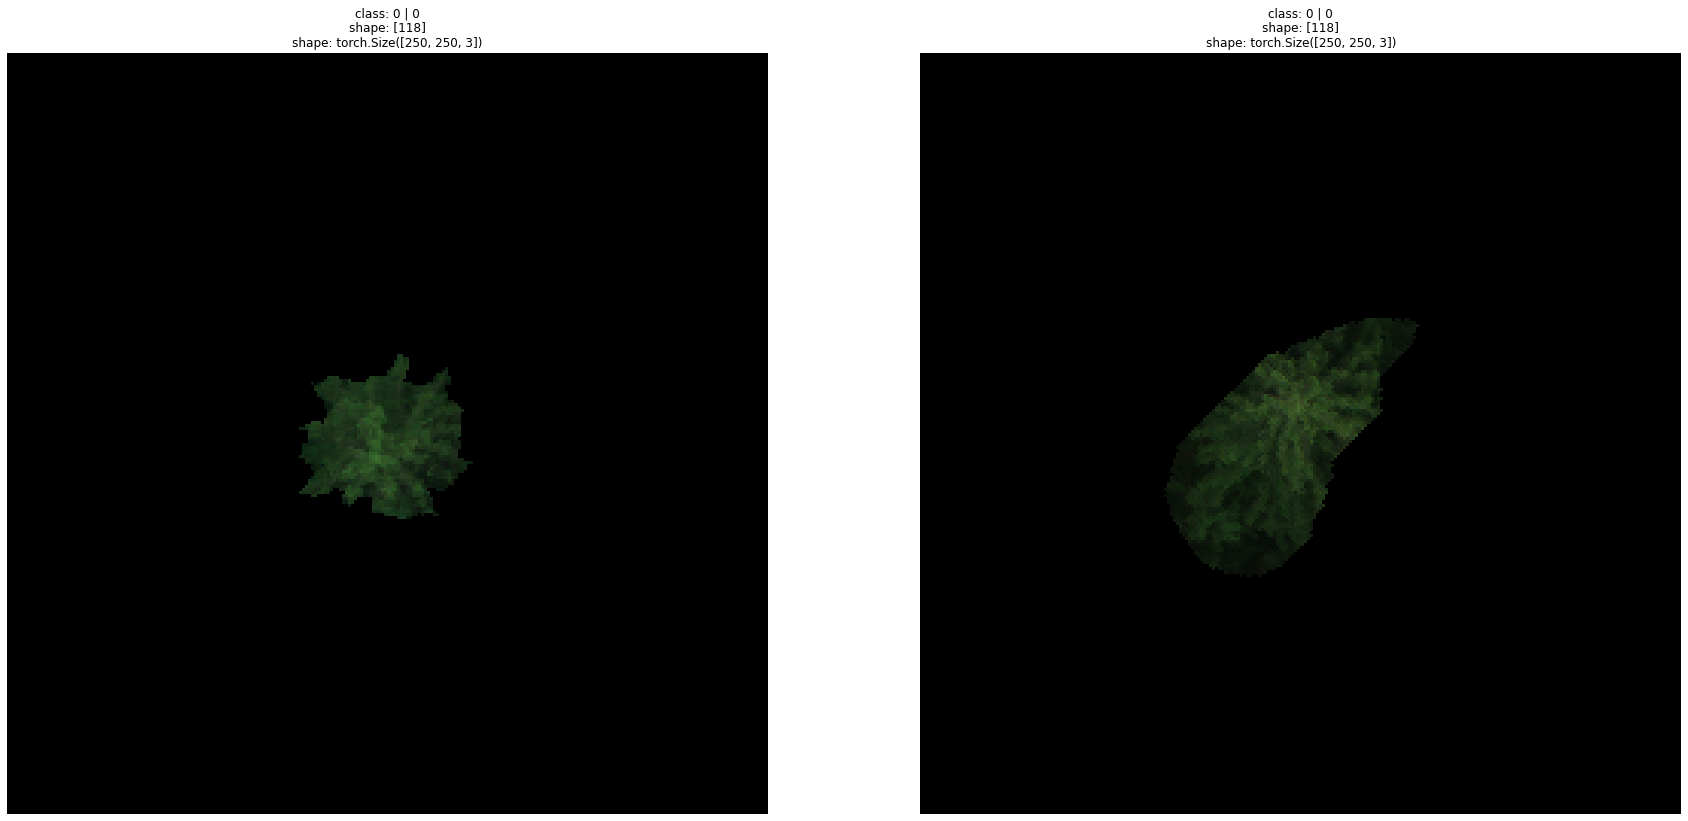

In [36]:
# enhance brightness in colorjitter for better visibility
visualization.display_random_images(train_dataset, 
                      n=2, 
                      classes=[0, 1, 2],
                      seed=None)


#### Check shape and data types of images and labels

In [13]:
img, label = test_dataset[10]
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image shape: torch.Size([3, 250, 250])
Image datatype: torch.float32
Image label: 0
Label datatype: <class 'int'>


#### Create PyTorch Dataloaders

In [13]:
# set seeds
g = torch.Generator()
g.manual_seed(0)
NUM_WORKERS=3 # should be changed, depending on the system used
batch_size=32

train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              persistent_workers=True,
                              pin_memory=True,
                              num_workers=NUM_WORKERS, 
                              generator=g,
                              sampler=sampler,
                              shuffle=False,
                              drop_last=True)

val_dataloader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             persistent_workers=True,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             drop_last=True)

test_dataloader = DataLoader(test_dataset,
                             batch_size=batch_size,
                             persistent_workers=True,
                             pin_memory=True,
                             num_workers=NUM_WORKERS,
                             shuffle=False,
                             drop_last=True)

print(f"Train dataloader size: {len(train_dataloader)}")
print(f"Val dataloader size: {len(val_dataloader)}")
print(f"Test dataloader size: {len(test_dataloader)}")

Train dataloader size: 419
Val dataloader size: 90
Test dataloader size: 78


#### Create and print model

In [21]:
# Create model
classes = train_dataset.class_names
num_classes = len(classes) # get output_shape (number of classes) as an argument for the model

effnet_b2 = create_effnetb2(output_shape=num_classes, dropout_rate=0.3, unfreeze=True, device=device)

NameError: name 'create_effnetb2' is not defined

In [25]:
# Print out model summary
summary(effnet_b2, 
        input_size=(32, 3, 250, 250), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=17,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape       Output Shape      Param #           Trainable
EfficientNet (EfficientNet)                                  [32, 3, 250, 250] [32, 3]           --                True
├─Sequential (features)                                      [32, 3, 250, 250] [32, 1408, 8, 8]  --                True
│    └─Conv2dNormActivation (0)                              [32, 3, 250, 250] [32, 32, 125, 125] --                True
│    │    └─Conv2d (0)                                       [32, 3, 250, 250] [32, 32, 125, 125] 864               True
│    │    └─BatchNorm2d (1)                                  [32, 32, 125, 125] [32, 32, 125, 125] 64                True
│    │    └─SiLU (2)                                         [32, 32, 125, 125] [32, 32, 125, 125] --                --
│    └─Sequential (1)                                        [32, 32, 125, 125] [32, 16, 125, 125] --                True
│    │    └─MBConv (0)       

#### Set model training parameters (multiple experiments possible)

In [15]:
# 5. set number of samples for each class to consider class imbalance

#weight_for_0 = (1 / neg) * (total / 2.0)
#weight_for_1 = (1 / pos) * (total / 2.0)



#loss_weight = torch.Tensor([3730, 7632, 6578, 553, 312]) # 5 classes
#loss_weight = torch.Tensor([11362, 6578, 553, 312]) # 4 classes


# Loss weight for 3 classes
#loss_weight = torch.Tensor([5.042, 1.274, 60.272]) # 3 classes | 0-10 = healthy, 15-95 = stressed, 99-100 = dead
#loss_weight = torch.Tensor([1.655, 2.637, 60.272]) # 3 classes | 0-25 = healthy, 30-95 = stressed, 99-100 = dead
#loss_weight = torch.Tensor([1.099, 12.732, 60.272]) # 3 classes| 0-45 = healthy, 50-95 = stressed, 99-100 = dead
#num_samples_class = [11362, 7131, 312] # 3 classes| 0-25 = healthy, 30-95 = stressed, 99-100 = dead
#num_samples_class = [16296, 2197, 312] # 3 classes| 0-40 = healthy, 45-95 = stressed, 99-100 = dead
#num_samples_class = [17016, 1477, 312] # 3 classes| 0-45 = healthy, 50-95 = stressed, 99-100 = dead
#num_samples_class = [5999, 748, 109] # Dataset_2020 only | 3 classes| 0-45 = healthy, 50-95 = stressed, 99-100 = dead
#loss_weight = [(1. / num_samples_class[i])*(6856 / 2.0) for i in range(len(num_samples_class))]
#loss_weight = [(1. / num_samples_class[i])*(18805 / 2.0) for i in range(len(num_samples_class))]
#loss_weight = torch.Tensor(loss_weight)
loss_weight = torch.Tensor([3.5,8,4.5])
print(f"Loss weights: {loss_weight}")
loss_weight = loss_weight.to(device)
# data 2020: [1194, 2516, 2776, 273, 97] (12 = NBV 99)
# data 2021: [1097, 2548, 2475, 203, 112] (2 = NBV 99)
# data 2022: [1439, 2568, 1327, 912, 88] (1 = NBV 99)

Loss weights: tensor([3.5000, 8.0000, 4.5000])


In [14]:
# 1. Create epochs list
num_epochs = [40]

# 2. Create models list (need to create a new model for each experiment)
models_list = ["effnet_b7"]

# 3. Create dataloaders dictionary for various dataloaders
train_dataloaders = {"train_data": train_dataloader}

# 4. Create target folder name were to save the tensorboard event files
target_dir = "ResNet_EffNet_log_evaluation"

In [26]:
###### define Parameters######
n_bands = 3 # define number of bands
classes = train_dataset.class_names
num_classes = len(classes)
lrs = [0.0011] # define learning rate
min_lr = 1e-7
#lr = 0.005 # define learning rate
dropout_rate = 0.5 #define dropout rate
unfreeze = True
gammas = [0.2] # how fast the learning rate decreases per epoch (low number=faster decrease)
#weights = [1, 2, 5] # weight for the focal loss to give more importance to the minority classes

# Define the number of epochs and the patience
patience = 10
step_size = 4
##############################

#import gc
# Force garbage collection
#gc.collect()
torch.cuda.empty_cache()


print(f"Memory allocated: {torch.cuda.memory_allocated()} bytes") 

Memory allocated: 1081815552 bytes


In [27]:
from torch.optim.lr_scheduler import _LRScheduler

class CustomStepLR(_LRScheduler):
    def __init__(self, optimizer, step_size, gamma=0.1, last_epoch=-1, min_lr=0):
        self.step_size = step_size
        self.gamma = gamma
        self.min_lr = min_lr
        super(CustomStepLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.step_size:
            return [base_lr for base_lr in self.base_lrs]
        else:
            lr = [base_lr * self.gamma ** (self.last_epoch // self.step_size) for base_lr in self.base_lrs]
            return [max(base_lr, self.min_lr) for base_lr in lr]

#### Start model training

In [28]:
%%time

# 1. Set the random seeds
set_seeds(seed=0)

# 2. Keep track of experiment numbers
experiment_number = 0

# 4. Loop through each number of epochs
for epochs in num_epochs:
    # 5. Loop through each model name and create a new model based on the name
    for model_name in models_list:
        # 6. Create information print outs
       
        
        # 7. Select the model
        
        
        #elif model_name == "effnet_b0_1":
        #    model = models.create_effnetb0(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
        #elif model_name == "effnet_b0_2":
        #    model = models.create_effnetb0(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
        #else:
        #    

        for gamma in gammas:
            for lr in lrs:
                
                # Remove variables and free up memory
                
                experiment_number += 1
                
                if model_name == "effnet_b7":
                    model = models.create_effnetb7(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
                if model_name == "ResNet152":
                    model = models.create_resnet152(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)
                print(f"[INFO] Experiment number: {experiment_number}")
                print(f"[INFO] Model: {model_name}")
                print(f"[INFO] Number of epochs: {epochs}")
                print(f"[INFO] Batch_size: {batch_size}")
                print(f"[INFO] Number of bands: {n_bands}")
                print(f"[INFO] Dropout rate: {dropout_rate}")
                print(f"[INFO] Gamma learning rate: {gamma}")
                #print(f"[INFO] Gamma FocalLoss: {weight}")
                
                # Create a new loss and optimizer for every model
                loss_fn = nn.CrossEntropyLoss()
                #loss_fn = FocalLoss(weights=weight)
                optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
                lr_scheduler = CustomStepLR(optimizer, step_size=step_size, gamma=gamma, min_lr=min_lr)
                #lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
                #lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=step_size, min_lr=min_lr)
                #lr_scheduler = ExponentialLR(optimizer, gamma=gamma)
                
                # Train target model with target dataloaders and track experiments
                results = train(model=model,
                                model_name=model_name,
                                n_bands=n_bands,
                                batch_size=batch_size,
                                train_dataloader=train_dataloader,
                                val_dataloader=val_dataloader, 
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                lr_scheduler=lr_scheduler,
                                num_classes=num_classes,
                                epochs=epochs,
                                experiment_num=experiment_number,
                                device=device,
                                writer=create_writer(target_dir=target_dir,
                                                     experiment_name='Evaluating_hyperparameters',
                                                     model_name=model_name,
                                                     extra=f"{epochs}_epochs"),
                                early_stop_patience = patience) 
                
                del loss_fn, optimizer, lr_scheduler, model, results
                torch.cuda.empty_cache()
                print("delete variables and empty cache...")
                
                print("-"*50 + "\n")

[INFO] Created new effnet_b7 model.
[INFO] Experiment number: 1
[INFO] Model: effnet_b7
[INFO] Number of epochs: 40
[INFO] Batch_size: 32
[INFO] Number of bands: 3
[INFO] Dropout rate: 0.5
[INFO] Gamma learning rate: 0.2
[INFO] Created SummaryWriter, saving to: ResNet_EffNet_log_evaluation\2023-04-05\Evaluating_hyperparameters\effnet_b7\40_epochs...


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 1 
Learning rate: 0.0011
Train loss: 0.6730 | Train precision: 0.6788 | Train recall: 0.6762 | Train f1score: 0.6775 | Train acc: 0.6676 | Train kappa: 0.4199 
Val loss: 0.2992 | Val precision: 0.6543 | Val recall: 0.5601 | Val f1score: 0.5529 | Val acc: 0.9358 | Val kappa: 0.2170 

Epoch: 2 
Learning rate: 0.0011
Train loss: 0.5831 | Train precision: 0.7559 | Train recall: 0.7477 | Train f1score: 0.7517 | Train acc: 0.7184 | Train kappa: 0.5129 
Val loss: 0.2428 | Val precision: 0.6363 | Val recall: 0.6403 | Val f1score: 0.6303 | Val acc: 0.9250 | Val kappa: 0.2950 

Epoch: 3 
Learning rate: 0.0011
Train loss: 0.5580 | Train precision: 0.7696 | Train recall: 0.7666 | Train f1score: 0.7681 | Train acc: 0.7346 | Train kappa: 0.5417 
Val loss: 0.6130 | Val precision: 0.4923 | Val recall: 0.7128 | Val f1score: 0.5047 | Val acc: 0.6788 | Val kappa: 0.1540 

Epoch: 4 
Learning rate: 0.0011
Train loss: 0.5452 | Train precision: 0.7735 | Train recall: 0.7719 | Train f1score: 0.7725 | T

In [22]:
## Setup the best model filepath
best_model_path = r"C:\Users\lwfeckesim\01_PyTorch\wze-uav\wze-uav-master\models\effnet_b7\1_effnet_b7_18_epochs.pth"

# Instantiate a new instance of EffNetB0 (to load the saved state_dict() to)
unfreeze=True
best_model = models.create_effnetb7(output_shape=num_classes, unfreeze=unfreeze, dropout_rate=dropout_rate, device=device)

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnet_b7 model.


<All keys matched successfully>

In [23]:
def make_predictions(model: torch.nn.Module, 
                     test_dataloader: torch.utils.data.DataLoader,
                     device: torch.device):
    # 1. Make predictions with trained model
    y_preds = []
    y_labels = []
    test_loss, test_precision, test_recall, test_f1_score, test_acc, test_prec_rec_fscore = 0, 0, 0, 0, 0, 0
    count = 0
    model.eval()
    
    # set up metrics
    pre_metrics = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
    rec_metrics = MulticlassRecall(num_classes=num_classes, average='macro').to(device)
    f1_metrics = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
    acc_metrics = MulticlassAccuracy(num_classes=num_classes, average='macro').to(device)
    
    with torch.inference_mode():
        for X, y in tqdm(test_dataloader, desc="Making predictions"):
            # Send data and targets to target device
            X, y = X.to(device), y.to(device)
            # Do the forward pass
            y_logit = model(X)
            # Turn predictions from logits -> prediction probabilities -> predictions labels
            y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
            # Put predictions on CPU for evaluation
            y_preds.append(y_pred.cpu())
            y_labels.append(y.cpu())
            
            #other metrics
            test_acc += ((y_pred == y).sum().item()/len(y_pred))
            y_pred_class = y_pred.detach().cpu().numpy() 
            y_class = y.detach().cpu().numpy()
            test_precision += precision_score(y_class, y_pred_class, average='macro', zero_division=1)
            test_recall += recall_score(y_class, y_pred_class, average='macro', zero_division=1)
            test_f1_score += f1_score(y_class, y_pred_class, average='macro', zero_division=1)
            #print(test_f1_score)
            #test_prec_rec_fscore += precision_recall_fscore_support(y_class, y_pred_class, average='macro')
            # collect all labels and predictions
            acc_metrics.update(y_pred, y)
            pre_metrics.update(y_pred, y)
            rec_metrics.update(y_pred, y)
            f1_metrics.update(y_pred, y)
    
    test_acc = test_acc / len(test_dataloader)
    # Concatenate list of predictions into a tensor
    y_pred_tensor = torch.cat(y_preds)
    y_labels_tensor = torch.cat(y_labels)
    test_f1_score = f1_score(y_labels_tensor.numpy(), y_pred_tensor.numpy(), average='macro', zero_division=0)
    test_precision = precision_score(y_labels_tensor.numpy(), y_pred_tensor.numpy(), average='macro', zero_division=0)
    test_recall = recall_score(y_labels_tensor.cpu().numpy(), y_pred_tensor.numpy(), average='macro', zero_division=0)
    test_precision2 = pre_metrics.compute().item()
    test_recall2 = rec_metrics.compute().item()
    test_f1_score2 = f1_metrics.compute().item()
    
    # Print classification report
    y_true = y_labels_tensor.detach().cpu().numpy()
    report = classification_report(y_true, y_pred_tensor.cpu().numpy(), target_names=class_names)
    print(report)
    
    return y_pred_tensor, y_labels_tensor, test_loss, test_recall, test_precision, test_f1_score, test_recall2, test_precision2, test_f1_score2, test_acc

Making predictions:   0%|          | 0/78 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     healthy       0.96      0.88      0.92      2228
    stressed       0.34      0.61      0.44       226
        dead       0.70      0.83      0.76        42

    accuracy                           0.85      2496
   macro avg       0.67      0.77      0.70      2496
weighted avg       0.90      0.85      0.87      2496

Test loss: 0
Test precision: 0.6659518046046397
Test recall: 0.772631423784885
Test F1score: 0.7042982219722874
Test Accuracy: 0.8529647435897436


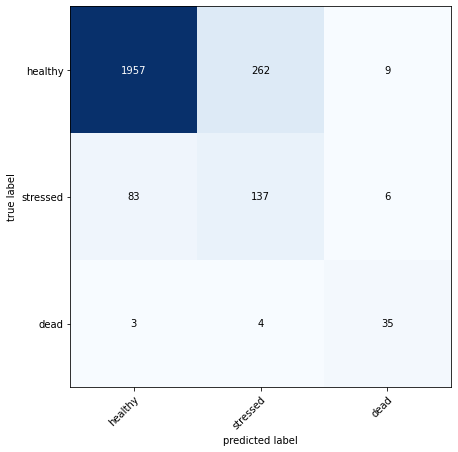

In [24]:
# 2. Setup confusion matrix instance and compare predictions to targets
#from wze_uav.analysis import *
y_pred_tensor, y_labels_tensor, test_loss, test_recall, test_precision, test_f1_score, test_recall2, test_precision2, test_f1_score2, test_acc = make_predictions(model=best_model,
                                 test_dataloader=test_dataloader, 
                                 device=device)

y_labels_tensor = y_labels_tensor.detach().cpu().numpy()
y_pred_tensor = y_pred_tensor.detach().cpu().numpy()

#confmat = ConfusionMatrix(num_classes=num_classes, task='multiclass')
#confmat_tensor = confmat(preds=y_pred_tensor,
#                         target=test_labels)
labels = np.array([0,1,2])
confmat = confusion_matrix(y_labels_tensor, y_pred_tensor, labels=labels)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat, # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

print(f"Test loss: {test_loss}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1score: {test_f1_score}") 
#print(f"Test F1score: {test_prec_rec_fscore}")
#print(f"Test Kappa: {test_kappa}")
print(f"Test Accuracy: {test_acc}")
#print(f"Test Logits: {y_logit}")
#print(f"Test Predictions: {y_pred.cpu().numpy()}")
#print(f"Test Labels: {y.cpu().numpy()}") 

In [58]:
print(f"Test loss: {test_loss}")
print(f"Test precision: {test_precision}")
print(f"Test recall: {test_recall}")
print(f"Test F1score: {test_f1_score}") 
print(f"Test precision: {test_precision2}")
print(f"Test recall: {test_recall2}")
print(f"Test F1score: {test_f1_score2}") 

Test loss: 0
Test precision: 0.7109413486597705
Test recall: 0.7409810346449421
Test F1score: 0.7002868516628092
Test precision: 0.7109413146972656
Test recall: 0.7409810423851013
Test F1score: 0.700286865234375


In [33]:
y_set.cpu()

NameError: name 'y_set' is not defined

In [141]:
test_dataset.labels

tensor([1, 0, 1,  ..., 0, 0, 0])

In [101]:
y_preds = []
y_labels = []
labels = np.array([0,1,2])
test_loss, test_precision, test_recall, test_f1_score, test_acc = 0, 0, 0, 0, 0
count = 0
model.eval()
with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        # Send data and targets to target device
        X, y = X.to(device), y.to(device)
        # Do the forward pass
        y_logit = model(X)
        # Turn predictions from logits -> prediction probabilities -> predictions labels
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        # Put predictions on CPU for evaluation
        y_preds.append(y_pred.cpu())
        y_labels.append(y.cpu())
        
        #other metrics
        test_acc += ((y_pred == y).sum().item()/len(y_pred))
        y_pred_class = y_pred.detach().cpu().numpy() 
        y_class = y.detach().cpu().numpy()
        test_precision += precision_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        test_recall += recall_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        #test_f1_score += f1_score(y_class, y_pred_class, average='macro', zero_division=1, labels=labels)
        
        #if count >= 1:
        #    y_set = torch.cat((y_set, y))
        #    count = count + 1
        #else:
        #    y_set = y
        #    count = count + 1
        
test_loss = test_loss / len(test_dataloader)
test_precision = test_precision / len(test_dataloader)
test_recall = test_recall / len(test_dataloader)
test_f1_score2 = test_f1_score / len(test_dataloader)
#test_kappa = test_kappa / len(dataloader)
test_acc = test_acc / len(test_dataloader)
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
#test_f1_score = f1_score(y_set.detach().cpu().numpy(), y_pred_tensor.cpu().numpy(), average='macro', zero_division=0, labels=[0,1,2])

# Print classification report
y_true = y_set.detach().cpu().numpy()
report = classification_report(y_true, y_pred_tensor.cpu().numpy(), target_names=class_names)
print(report)

Making predictions:   0%|          | 0/78 [00:00<?, ?it/s]

NameError: name 'y_set' is not defined

In [140]:
test_f1_score

0.528680154128826

In [122]:
make = (y_class == y_pred_class)
make

array([ True,  True,  True, False,  True, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True])

In [99]:
torch.softmax(y_logit, dim=1).argmax(dim=1)

tensor([0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [101]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

In [112]:
test = (y_pred == y).sum().item()/16

In [113]:
test

0.8125

In [114]:
 y_pred_class = y_pred.detach().cpu().numpy() 

In [115]:
y_pred_class

array([0, 0, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)